# Import prayers, ritual texts, etc. and output their syntactic structures

In [2]:
##this program reads in files from local drive, both bible and mesopotamia, and outputs csv data, plots "active god" and "passive god:
## scores on a 2d plot, and calculates cosine similarity between the activegod scores in mesopotamia and bible.

## Import packages
from pathlib import Path
import os
import re

import pandas as pd
import numpy as np
import umap.umap_ as umap
import glob
import csv
import sys
import spacy

from bs4 import BeautifulSoup
from spacy.symbols import nsubj, VERB
from spacy.lang.en import English

## Functions
# select for names of God

def Mis_god(variable):
    names = ["Marduk", "Enlil", "Apsû", "Tia-mat", "Lah(mu", "Lah(amu", "Anšar", "Kišar", "Anu", "Nudimmud", 
             "Mummu", "Ea", "Damkina", "Be-l", "Mari-utu", "H(ubur", "Qingu", "Kaka", "Šamaš", "Usmû", "Enki",
             "Abzu", "An", "Nunamnir", "Elil", "Nishiku", "Utu", "Shamash", "Nanna-Suen", "Nanna", "Enzu", "Zuen", "Suen", "Sin", "Nergal", 
             "Nabu", "Inanna", "Ishtar", "Ninurta", "Ningirsu", "Tiamat", "Anshar", "Kishar", "Ki", "Nammu",
             "Ashur", "Dagan", "Dumuzid", "Tammuz", "Ereshkigal", "Geshtinanna", "Gilgamesh", "Gula", "Nintunugga",
             "Ninkarrak", "Meme", "Bau", "Ninisina", "Ishkur", "Adad", "Ishtaran", "Ištaran", "Nanshe", "Ninazu", "Ningal",
             "Nikkal", "Ningishzida", "Ninhursag", "Damgainuna", "Ninmah", "Ninlil", "Ninshubur", "Nisaba"]
    if (variable in names):
        return True
    else:
        return False
    
def Bis_god(variable):
    names = ["YHWH","Lord","God","Yahweh"]
    
    if (variable in names):
        return True
    else:
        return False
    
def weird_division(n, d): #handle divide by zero
    return n / d if d else 0


# start code for extracting text 


nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

Afilename = []
Pfilename = []
Asubject = [] # initilize activegod variables
Averb = []
Ad_object = []
Asentence = []

Psubject = [] #initialize passivegod variables
Pverb = []
Pd_object = []
Psentence = []

Mgodstats = {}
Mgodstatsdf = pd.DataFrame(Mgodstats)

## read in the .html files from https://etcsl.orinst.ox.ac.uk/index1.htm for sumerian texts
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://etcsl.orinst.ox.ac.uk/section4/tr4072.htm" #Inanna
#url = "https://etcsl.orinst.ox.ac.uk/section2/tr285b.htm"  #Marduk
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# make one long string
text = ' '.join(chunk for chunk in chunks if chunk)
# get rid of (parenthetical comments)
text = re.sub("[\(\[].*?[\)\]]", "", text)
# add newlines to replace any numbers in the text
text = re.sub('\d', '\n', text)
# break into sentences
text = re.sub("\. ", ".\n", text)
#get rid of excess newlines
text = re.sub("\n\n", "\n", text)
text = re.sub("\n\n", "\n", text)
text = re.sub("\n\n", "\n", text)



path = './mesopotamia/*.txt'
for file in glob.glob(path):
    
    actingGod = 0
    godNumber = 0
    objectGod = 0
    speakingGod = 0
    sentences = 0
    words = 0
    
    
    with open(file, encoding='utf-8', errors='ignore') as file_in:
        text = file_in.read()
        newtext = " ".join(text.split())  # make the lines in the textfile cleaner, get rid of whitespaces
        doc = nlp(newtext)
        
        
        for sent in doc.sents: #iterate over sentences
            sentences += 1
            for god in sent:   #iterate over words 
                words += 1
                if Mis_god(god.text):   #if a word is a name of god, extract dependencies for verb and dobj            
                    godNumber += 1
                    #print (sent)
                
                    if god.dep_ == "nsubj" and god.head.pos_ == "VERB":
                        for direct_object in god.head.children:
                            if direct_object.dep_ == "dobj": # active forms with dobj
                                actingGod += 1
                                #print (god.text + " " + god.head.text + " " + direct_object.text + "/// God acting on direct object") 
                                Afilename.append(file)
                                Asubject.append(god.text)
                                Averb.append(god.head.text)
                                Ad_object.append(direct_object.text)
                                Asentence.append(" ".join(sent.text.split()))  # this gets rid of extra whitespaces
                    
                    elif god.dep_ == "nsubj" :
                        actingGod += 1
                        #print (god.text, god.head.text, "/// Active divinity") 
                        Afilename.append(file)
                        Asubject.append(god.text)
                        Averb.append(god.head.text)
                        Ad_object.append(" //")
                        Asentence.append(" ".join(sent.text.split()))  # this gets rid of extra whitespaces
                                
                    if god.dep_ == "dobj":  
                        for child in god.head.children:
                            oneChild = False
                            if child.dep_ == "nsubj":   # passive forms
                                oneChild = True
                                Pfilename.append(file)
                                Psubject.append(child)
                                Pverb.append(god.head.text)
                                Pd_object.append(god.text)
                                Psentence.append(" ".join(sent.text.split()))
                                objectGod += 1
                                #print (child.text + " " + god.head.text + " " + god.text + "///   God as object")
                            elif oneChild == True:
                                objectGod += 1
                                #print ([token.text for token in god.lefts], god.text + "/// God as object, not sure what subject")
                                Pfilename.append(file)
                                Psubject.append(" // ")
                                Pverb.append(god.head.text)
                                Pd_object.append(god.text)
                                Psentence.append(" ".join(sent.text.split()))
                    
                    if god.head.lemma_ == "say" or god.head.lemma_ == "speak":
                        speakingGod += 1
                        #print (god.text, god.head.text, "///   God is loquacious")
                        
    # increment counts, prepare dataframe with statistics for each file                    
    print ("God acted " + str(actingGod) + " times")
    print ("God was treated as an object " + str(objectGod) + " times")
    print ("God spoke " + str(speakingGod) + " times")
    print ("Out of " + str(godNumber) + " times the Name of God was found")
    
    newrow = {'File':file, 'Active':str(actingGod), 'Objectified':str(objectGod), 'Speaking':str(speakingGod), 'Named':str(godNumber), 
              'Mes_Ascore':weird_division(actingGod, godNumber), 'Mes_Oscore':weird_division(objectGod, godNumber), 'Mes_Sscore':weird_division(speakingGod,godNumber)}
    Mgodstatsdf = Mgodstatsdf.append(newrow, ignore_index=True)

a = {'file': Afilename, 'subject': Asubject, 'verb': Averb, 'direct object': Ad_object, 'sentence': Asentence}
p = {'file': Pfilename, 'subject': Psubject, 'verb': Pverb, 'direct object': Pd_object, 'sentence': Psentence}                            
dfA = pd.DataFrame(a, columns=['file','subject','verb', 'direct object', 'sentence'])
dfP = pd.DataFrame(p, columns=['file','subject','verb', 'direct object', 'sentence'])
#dfP.head()  

dfA.to_csv('../EADHproject/MESactiveGod.csv') # output dataframe to the project folder
dfP.to_csv('../EADHproject/MESpassiveGod.csv')
Mgodstatsdf.to_csv('../EADHproject/MESgodstats.csv')
 
print ("MESOPOTAMIA: " + str(sentences) + " sentences processed, and " + str(words) + " words processed.")

# start bible extraction

Afilename = []
Pfilename = []
Asubject = [] # initilize activegod variables
Averb = []
Ad_object = []
Asentence = []

Psubject = [] #initialize passivegod variables
Pverb = []
Pd_object = []
Psentence = []

Bgodstats = {}
Bgodstatsdf = pd.DataFrame(Bgodstats)

path = './bible/*.txt'

for file in glob.glob(path):
    
    actingGod = 0
    godNumber = 0
    objectGod = 0
    speakingGod = 0
    sentences = 0
    words = 0
    
    
    with open(file, encoding='utf-8', errors='ignore') as file_in:
        text = file_in.read()
        newtext = " ".join(text.split())  # make the lines in the textfile cleaner, get rid of whitespaces
        doc = nlp(newtext)
        
        
        for sent in doc.sents: #iterate over sentences
            sentences += 1
            for god in sent:   #iterate over words 
                words += 1
                if Bis_god(god.text):   #if a word is a name of god, extract dependencies for verb and dobj            
                    godNumber += 1
                    #print (sent)
                
                    if god.dep_ == "nsubj" and god.head.pos_ == "VERB":
                        for direct_object in god.head.children:
                            if direct_object.dep_ == "dobj": # active forms with dobj
                                actingGod += 1
                                #print (god.text + " " + god.head.text + " " + direct_object.text + "/// God acting on direct object") 
                                Afilename.append(file)
                                Asubject.append(god.text)
                                Averb.append(god.head.text)
                                Ad_object.append(direct_object.text)
                                Asentence.append(" ".join(sent.text.split()))  # this gets rid of extra whitespaces
                    
                    elif god.dep_ == "nsubj" :
                        actingGod += 1
                        #print (god.text, god.head.text, "/// Active divinity") 
                        Afilename.append(file)
                        Asubject.append(god.text)
                        Averb.append(god.head.text)
                        Ad_object.append(" //")
                        Asentence.append(" ".join(sent.text.split()))  # this gets rid of extra whitespaces
                                
                    if god.dep_ == "dobj":  
                        for child in god.head.children:
                            oneChild = False
                            if child.dep_ == "nsubj":   # passive forms
                                oneChild = True
                                Pfilename.append(file)
                                Psubject.append(child)
                                Pverb.append(god.head.text)
                                Pd_object.append(god.text)
                                Psentence.append(" ".join(sent.text.split()))
                                objectGod += 1
                                #print (child.text + " " + god.head.text + " " + god.text + "///   God as object")
                            elif oneChild == True:
                                objectGod += 1
                                #print ([token.text for token in god.lefts], god.text + "/// God as object, not sure what subject")
                                Pfilename.append(file)
                                Psubject.append(" // ")
                                Pverb.append(god.head.text)
                                Pd_object.append(god.text)
                                Psentence.append(" ".join(sent.text.split()))
                    
                    if god.head.lemma_ == "say" or god.head.lemma_ == "speak":
                        speakingGod += 1
                        #print (god.text, god.head.text, "///   God is loquacious")
                        
    # increment counts, prepare dataframe with statistics for each file                    
    print ("God acted " + str(actingGod) + " times")
    print ("God was treated as an object " + str(objectGod) + " times")
    print ("God spoke " + str(speakingGod) + " times")
    print ("Out of " + str(godNumber) + " times the Name of God was found")
    
    newrow = {'File':file, 'Active':str(actingGod), 'Objectified':str(objectGod), 'Speaking':str(speakingGod), 'Named':str(godNumber), 
              'Bib_Ascore':weird_division(actingGod, godNumber), 'Bib_Oscore':weird_division(objectGod, godNumber), 'Bib_Sscore':weird_division(speakingGod,godNumber)}
    Bgodstatsdf = Bgodstatsdf.append(newrow, ignore_index=True)

a = {'file': Afilename, 'subject': Asubject, 'verb': Averb, 'direct object': Ad_object, 'sentence': Asentence}
p = {'file': Pfilename, 'subject': Psubject, 'verb': Pverb, 'direct object': Pd_object, 'sentence': Psentence}                            
dfA = pd.DataFrame(a, columns=['file','subject','verb', 'direct object', 'sentence'])
dfP = pd.DataFrame(p, columns=['file','subject','verb', 'direct object', 'sentence'])
#dfP.head()  

dfA.to_csv('../EADHproject/BIBLEactiveGod.csv') # output dataframe to the project folder
dfP.to_csv('../EADHproject/BIBLEpassiveGod.csv')
Bgodstatsdf.to_csv('../EADHproject/BIBLEgodstats.csv')

print ("BIBLE: " + str(sentences) + " sentences processed, and " + str(words) + " words processed.")





God acted 2 times
God was treated as an object 0 times
God spoke 0 times
Out of 23 times the Name of God was found
God acted 0 times
God was treated as an object 0 times
God spoke 0 times
Out of 13 times the Name of God was found
God acted 2 times
God was treated as an object 0 times
God spoke 1 times
Out of 11 times the Name of God was found
God acted 0 times
God was treated as an object 0 times
God spoke 0 times
Out of 4 times the Name of God was found
God acted 0 times
God was treated as an object 0 times
God spoke 0 times
Out of 2 times the Name of God was found
God acted 0 times
God was treated as an object 0 times
God spoke 1 times
Out of 31 times the Name of God was found
God acted 4 times
God was treated as an object 2 times
God spoke 0 times
Out of 36 times the Name of God was found
God acted 3 times
God was treated as an object 0 times
God spoke 0 times
Out of 6 times the Name of God was found
God acted 0 times
God was treated as an object 0 times
God spoke 0 times
Out of 4 t

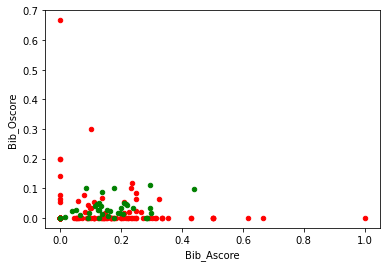

In [3]:

#2d scatter plot


ax1 = Mgodstatsdf.plot(kind='scatter', x='Mes_Ascore', y='Mes_Oscore', color='r')    #Mesopotamian data in red
ax2 = Bgodstatsdf.plot(kind='scatter', x='Bib_Ascore', y='Bib_Oscore', color='g', ax=ax1)  #Biblical data in green





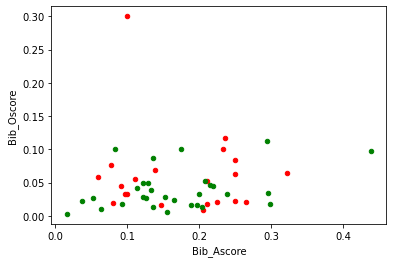

In [4]:
#2d scatter plot removing zero values from dataframe

Acols = ['Bib_Ascore']
Ocols = ['Bib_Oscore']

Mgodstatsdf['Mes_Ascore'] = Mgodstatsdf[Mgodstatsdf['Mes_Ascore'] > 0]['Mes_Ascore'] 
Mgodstatsdf.dropna()

Bgodstatsdf['Bib_Ascore'] = Bgodstatsdf[Bgodstatsdf['Bib_Ascore'] > 0]['Bib_Ascore']
Bgodstatsdf.dropna()

Mgodstatsdf['Mes_Oscore'] = Mgodstatsdf[Mgodstatsdf['Mes_Oscore'] > 0]['Mes_Oscore']
Mgodstatsdf.dropna()

Bgodstatsdf['Bib_Oscore'] = Bgodstatsdf[Bgodstatsdf['Bib_Oscore'] > 0]['Bib_Oscore']
Bgodstatsdf.dropna()

ax1 = Mgodstatsdf.plot(kind='scatter', x='Mes_Ascore', y='Mes_Oscore', color='r')    #Mesopotamian data in red
ax2 = Bgodstatsdf.plot(kind='scatter', x='Bib_Ascore', y='Bib_Oscore', color='g', ax=ax1)  #Biblical data in green




In [5]:
#start with some simple averages

def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

#measure cosine similarity between Mesopotamia and Bible
from numpy import dot
from numpy.linalg import norm

#define lists

a = Mgodstatsdf["Mes_Ascore"].values.tolist()  #here we are only comparing Active 
b = Bgodstatsdf["Bib_Ascore"].values.tolist()

a = [str(x) for x in a]
anewlist = [x for x in a if x != 'nan']
b = [str(x) for x in b]
bnewlist = [x for x in b if x != 'nan']
a = [float(i) for i in anewlist]
b = [float(i) for i in bnewlist]

# do passive god part here
c = Mgodstatsdf["Mes_Oscore"].values.tolist()  #here we are only comparing Passive 
d = Bgodstatsdf["Bib_Oscore"].values.tolist()

c = [str(x) for x in c]
cnewlist = [x for x in c if x != 'nan']
d = [str(x) for x in d]
dnewlist = [x for x in d if x != 'nan']
c = [float(i) for i in cnewlist]
d = [float(i) for i in dnewlist]

print ("On average, Mesopotamian gods are " + str(cal_average(a)*100) + " percent active, whereas the Biblical god is " + str(cal_average(b)*100) + " percent active.")
print ("On average, Mesopotamian gods are " + str(cal_average(c)*100) + " percent objectified, whereas the Biblical god is " + str(cal_average(d)*100) + " percent objectified.")

  
#calculate Cosine Similarity. But actually it doesn't mean anything, the two vectors are in two entirely different spaces.
diff = len(a)-len(b)
for i in range(diff):  #make lists the same length (EXPECTED: mes texts will be more than bible texts)
    b.append(0)
  
#cos_sim = dot(a, b)/(norm(a)*norm(b))
#print ("Completely meaningless: Cosine similarity between Mesopotamian and Biblical 'active god' scores is " + str(cos_sim))



On average, Mesopotamian gods are 22.057045744120245 percent active, whereas the Biblical god is 17.372750019624092 percent active.
On average, Mesopotamian gods are 9.57170188411071 percent objectified, whereas the Biblical god is 3.9655537474190012 percent objectified.
